[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.1041
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0088
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0054
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0049
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0040
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0047
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0038
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0040
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0039
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0035
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

LSTM RMSE: 5.6533
LSTM MAE: 4.5968
ARIMA RMSE: 2.6138
ARIMA MAE: 2.0480


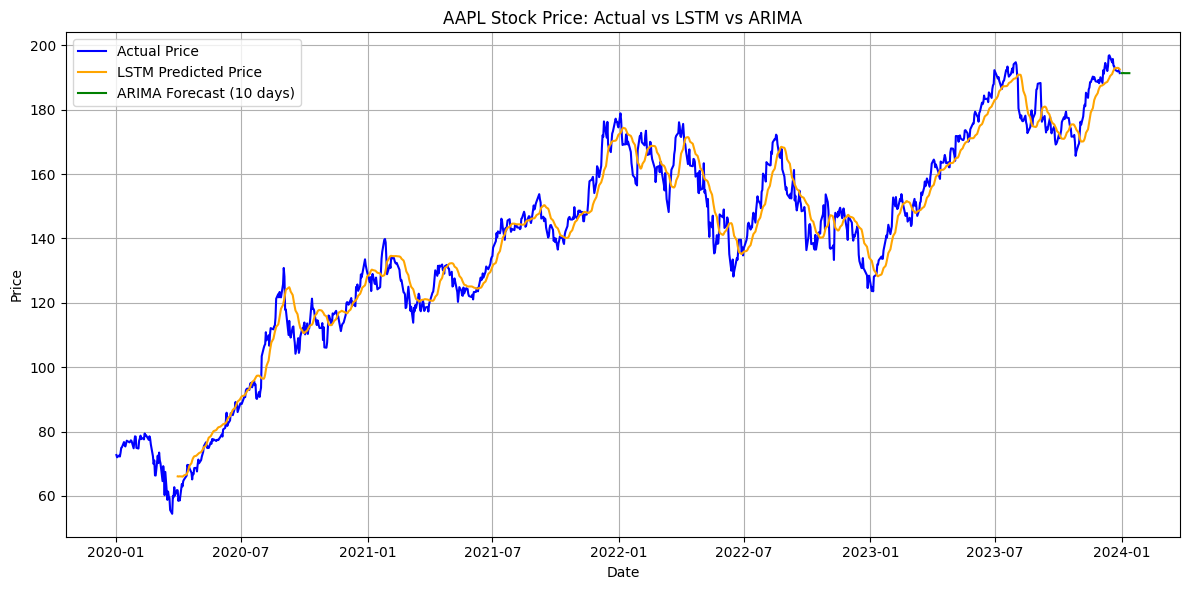

LSTM Predictions (sample): [66.0763   66.02457  66.086296 66.0725   66.04763  65.97631  66.10956
 66.34693  66.71787  67.18398 ]
ARIMA Forecast: 1006    191.373090
1007    191.369641
1008    191.383895
1009    191.406321
1010    191.364235
1011    191.364960
1012    191.365387
1013    191.366287
1014    191.367357
1015    191.365633
Name: predicted_mean, dtype: float64


In [10]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA
import torch
from transformers import BertModel, BertTokenizer

# Download and clean stock data
def get_stock_data(ticker, start, end):
    df = yf.download(ticker, start=start, end=end)
    df = df[['Close']].dropna()
    df['Close'] = df['Close'].astype(float)
    return df

# Prepare LSTM data
def prepare_lstm_data(data, time_step=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))
    X, Y = [], []
    for i in range(len(data_scaled) - time_step - 1):
        X.append(data_scaled[i:(i + time_step), 0])
        Y.append(data_scaled[i + time_step, 0])
    return np.array(X), np.array(Y), scaler

# Build LSTM Model
def build_lstm_model():
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(60, 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train and predict using ARIMA
def arima_forecast(data, steps=10):
    model = ARIMA(data, order=(5, 1, 0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return forecast

# Transformer-based prediction (placeholder example)
def transformer_prediction(text_data):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    inputs = tokenizer(text_data, return_tensors='pt', truncation=True, padding=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Compute error metrics (RMSE & MAE)
def compute_errors(true, predicted):
    rmse = np.sqrt(mean_squared_error(true, predicted))
    mae = mean_absolute_error(true, predicted)
    return rmse, mae

# Main Execution
if __name__ == "__main__":
    ticker = "AAPL"
    start_date = "2020-01-01"
    end_date = "2024-01-01"

    # Load and clean data
    df = get_stock_data(ticker, start_date, end_date)
    stock_data = df['Close']

    # LSTM Processing
    time_step = 60
    X, Y, scaler = prepare_lstm_data(stock_data)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    lstm_model = build_lstm_model()
    lstm_model.fit(X, Y, epochs=10, batch_size=32, verbose=1)

    lstm_predictions = lstm_model.predict(X)
    lstm_predictions = scaler.inverse_transform(lstm_predictions)

    # ARIMA Prediction
    arima_preds = arima_forecast(stock_data)

    # Compute error metrics for LSTM
    actual_lstm = stock_data[time_step+1: time_step+1+len(lstm_predictions)]
    rmse_lstm, mae_lstm = compute_errors(actual_lstm[:len(lstm_predictions)], lstm_predictions.flatten())

    # Print LSTM error metrics
    print(f"LSTM RMSE: {rmse_lstm:.4f}")
    print(f"LSTM MAE: {mae_lstm:.4f}")

    # Compute error metrics for ARIMA (for the last 10 actual values)
    arima_actual = stock_data[-10:].values
    rmse_arima, mae_arima = compute_errors(arima_actual, arima_preds)

    # Print ARIMA error metrics
    print(f"ARIMA RMSE: {rmse_arima:.4f}")
    print(f"ARIMA MAE: {mae_arima:.4f}")

    # Plot comparison
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data.index, stock_data, label='Actual Price', color='blue')
    plt.plot(stock_data.index[-len(lstm_predictions):], lstm_predictions, label='LSTM Predicted Price', color='orange')

    # Forecasted ARIMA values (extend index for future predictions)
    forecast_index = pd.date_range(start=stock_data.index[-1], periods=len(arima_preds)+1, freq='B')[1:]
    plt.plot(forecast_index, arima_preds, label='ARIMA Forecast (10 days)', color='green')

    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"{ticker} Stock Price: Actual vs LSTM vs ARIMA")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print a sample
    print("LSTM Predictions (sample):", lstm_predictions.flatten()[:10])
    print("ARIMA Forecast:", arima_preds)
